<a href="https://colab.research.google.com/github/silprosa/fynesse_mlfc/blob/main/proj/Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
%pip install osmnx


In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:

household = pd.read_stata('/content/drive/MyDrive/knhs/Household_Information_Data.dta')
individual = pd.read_stata('/content/drive/MyDrive/knhs/Individual_Data.dta')



# **Understanding the data**
**individual data**

this data contains 80889 individuals in  21347 households




In [5]:
display(len(individual))
display(len(individual['interview__key'].unique()))
display(len(individual['interview__id']))
display(len(individual['interview__id'].unique()))


80889

21347

80889

21347

In [86]:
individual.iloc[8000:80010

,interview__key,interview__id,a01,hhid__id,b02_1,b03,b03_other,b04,b05_years,b05_yrofbirth,...,ken_edu_attendance,edu_attendance,birthplace,relationship_details,mrts_details,age_dep,hhsize,size,wap,age_group
8000,90-59-05-73,65Abedf5C3704D6B9Bf57C7B22De0959,Taita-Taveta,3,Yes,SON OR DAUGHTER,,Male,11,2013.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,5.0,5-6 persons,1.0,Age 5-11
8001,60-22-60-35,A623Fdc571474B898D45Fb7Ed04F4C0B,Taita-Taveta,5,Yes,SON OR DAUGHTER,,Male,14,2010.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,9.0,9-10 persons,1.0,Age 12-14
8002,78-56-88-71,A85A774E2Fca4D4391440392297E2Ff1,Taita-Taveta,4,Yes,SON OR DAUGHTER,,Male,14,2009.0,...,1 - Attending,Secondary Education,1 - Native-born,3 - Child / Son / Daughter,NaN,0-14,5.0,5-6 persons,1.0,Age 12-14
8003,60-22-60-35,A623Fdc571474B898D45Fb7Ed04F4C0B,Taita-Taveta,3,Yes,SON OR DAUGHTER,,Male,19,2004.0,...,2 - Not attending,Secondary Education,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,9.0,9-10 persons,1.0,NaN
8004,37-58-68-13,861Fb4B81Bc947C69Db1A33Af4Db1Af2,Taita-Taveta,4,Yes,SON OR DAUGHTER,,Male,15,2009.0,...,1 - Attending,Primary education,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,4.0,3-4 persons,1.0,Age 15-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,15-84-23-67,0F886Ffaad1F46Fdb802639E71A6E2Ae,Nairobi City,1,Yes,HEAD,,Female,22,2002.0,...,1 - Attending,Middle level college,1 - Native-born,1 - Reference person / Head,NEVER MARRIED,15-64,2.0,1-2 persons,1.0,NaN
80006,62-91-56-59,3Afcd1E95A614B4Eb3981A48E5B54Fe6,Nairobi City,3,No,SON OR DAUGHTER,,Female,23,2001.0,...,1 - Attending,Bachelor's or equivalent level,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,5.0,5-6 persons,1.0,NaN
80007,23-07-02-83,37C8Ae0Ddc884E0C8Ba306561C8Dae7A,Nairobi City,2,Yes,NEPHEW/NIECE,,Female,21,2002.0,...,1 - Attending,Middle level college,1 - Native-born,7 NEPHEW/NIECE,NEVER MARRIED,15-64,3.0,3-4 persons,1.0,NaN
80008,97-95-47-66,5D92D117B6324Dec92Ec818Ffe9Bdadd,Nairobi City,3,Yes,SON OR DAUGHTER,,Female,20,2003.0,...,1 - Attending,Middle level college,1 - Native-born,3 - Child / Son / Daughter,NEVER MARRIED,15-64,4.0,3-4 persons,1.0,NaN


In [106]:
household.head()

,interview__key,interview__id,a01,countycode,a07_1,serial,a12,c01_1,c01_1other,c01_2,...,med_prop,med_brms,hhweight,tag,internet,year_occ,pln,sf,duration,bf
0,00-00-55-14,8a585d4dd71641b8a1348be6cc11e121,Laikipia,31,Urban,35312800,6,PUBLIC WATER COMPANIES,,PIPED TO YARD/PLOT,...,NaN,NaN,182.414370,1,1.0,NaN,NaN,NaN,NaN,Electrical Engineer
1,00-01-22-52,d155c88b64de40148cda8dd079c36baa,Embu,14,Urban,44136136,3,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,...,0.2,NaN,199.056467,1,1.0,1 to 10 YEARS,NaN,NaN,NaN,NaN
2,00-02-11-67,b511ae4612704d9b9d395c901d975644,Vihiga,38,Urban,99694240,7,WATER FROM SPRING (Protected),,FETCHED BY HOUSEHOLD,...,NaN,NaN,142.092291,1,1.0,NaN,NaN,NaN,NaN,NaN
3,00-02-70-91,e1ff2d92960947d8adc30f55ff666b15,Garissa,07,Rural,92351040,6,DUG WELL (Unprotected),,FETCHED BY HOUSEHOLD,...,NaN,NaN,337.176211,1,NaN,NaN,NaN,NaN,2 to 3 years,NaN
4,00-02-78-46,522414c7575543ddb88782491aa5e190,Embu,14,Urban,26181404,4,PUBLIC WATER COMPANIES,,PIPED INTO DWELLING,...,0.2,3.0,183.463710,1,NaN,1 to 10 YEARS,NaN,NaN,NaN,NaN


Extract relevant features from the individual dataset i.e identifier,age,gender...

In [105]:
df = (
    individual[["interview__key", "interview__id", "a01", "b04","b05_years", "b10", "b11", "b12", "b13","edu_attendance"]].copy()
    .rename(
        columns={
            "interview__key": "interview_key",
            "interview__id": "interview_id",
            "b04": "gender",
            "b05_years": "age",
            "a01": "county",
            "b10": "ever_schooled",
            "b11": "currently_schooling",
            "b12": "current_level",
            "b13": "highest_level",
            "edu_attendance": "education_level"
        }
    )
)
df.iloc[79990:80000]

,interview_key,interview_id,county,gender,age,ever_schooled,currently_schooling,current_level,highest_level,education_level
79990,18-63-12-82,3925533C18Dc43C098A5Cf576A5832D8,Nairobi City,Female,23,Yes,No,NaN,FORM 3,Secondary Education
79991,17-96-70-67,0C276F453Ac1436Ebf093F74F3F5C384,Nairobi City,Female,23,Yes,No,NaN,FORM 4,Secondary Education
79992,56-52-58-80,47B66635Ffb745F0A46A8835C69947F2,Nairobi City,Female,24,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,Bachelor's or equivalent level
79993,17-59-45-88,1F084Cbba63A4Dcb93Cb0B7Bc79D6Ee8,Nairobi City,Female,24,Yes,No,NaN,FORM 2,Secondary Education
79994,54-92-39-46,168C68E00Cd446D08Ba4806C814F3Fe3,Nairobi City,Female,24,Yes,No,NaN,STANDARD 8,Primary education
79995,20-32-10-51,7Fe37F5De7E04F7580C9Db8Fb0A99A58,Nairobi City,Female,24,Yes,No,NaN,FORM 4,Secondary Education
79996,51-21-55-82,3Ea3500318034D2Ebb84Ff50D34B6Db1,Nairobi City,Female,24,Yes,No,NaN,FORM 4,Secondary Education
79997,66-25-26-17,2D5882C480Db47Dfb920D6E763398140,Nairobi City,Female,24,Yes,No,NaN,FORM 4,Secondary Education
79998,27-98-59-56,32Dead41Fbe047Cf9C2B093Eafeec816,Nairobi City,Female,20,Yes,No,NaN,MIDDLE LEVEL COLLEGE/POST SECONDARY TVET DIPLO...,Middle level college
79999,43-38-34-85,Ca5Df53B2Bd14E06971338D31782Bcc1,Nairobi City,Female,20,Yes,Yes,UNIVERSITY UNDERGRADUATE DEGREE YEAR 1,FORM 4,Secondary Education


Extract relevant features from the houshold dataset i.e distance to the nearest school , internet access..., will add more

In [109]:
household["bf"].value_counts()

,count
bf,
Other,1011
Electrical Engineer,330
Architect,229
Planner,213
Structural Engineer,177
Civil Engineer,156
Land surveyor,110
Interior designer,59
Valuer,28


In [114]:
df2 = household.copy()
household.tail()

,interview__key,interview__id,a01,countycode,a07_1,serial,a12,c01_1,c01_1other,c01_2,...,med_prop,med_brms,hhweight,tag,internet,year_occ,pln,sf,duration,bf
21342,99-98-70-63,afc22e7be2d5499d800c2ada00ad31b4,Tana River,04,Urban,26008480,4,TUBE WELL OR BOREHOLE (Community),,FETCHED BY HOUSEHOLD,...,NaN,NaN,75.510090,1,1.0,NaN,NaN,NaN,NaN,NaN
21343,99-99-09-18,287441c9785f46729798c39be4c6a758,Nandi,29,Rural,17571512,4,SURFACE WATER (RIVER/DAM/LAKE/POND/STREAM/CANA...,,FETCHED BY HOUSEHOLD,...,NaN,NaN,748.861619,1,NaN,NaN,NaN,NaN,NaN,Architect
21344,99-99-15-55,4cc6bc75ce464f128e54f99757407ce9,Wajir,08,Rural,20358798,7,PUBLIC WATER COMPANIES,,PUBLIC TAP/STANDPIPE,...,NaN,NaN,171.354569,1,NaN,NaN,NaN,NaN,NaN,NaN
21345,99-99-32-84,1e7a7a1f912842dfb9ef80606e51698d,Mandera,09,Rural,19768270,5,SURFACE WATER (RIVER/DAM/LAKE/POND/STREAM/CANA...,,CART WITH SMALL TANK,...,NaN,NaN,762.777121,1,NaN,NaN,NaN,NaN,2 to 3 years,NaN
21346,99-99-55-22,10aaef5340474566a671d44dc2a1482e,Siaya,41,Rural,16892212,1,DUG WELL (Protected),,FETCHED BY HOUSEHOLD,...,NaN,NaN,847.140700,1,NaN,NaN,NaN,NaN,4 to 6 years,NaN


In [61]:
nan_count = df.isna().sum()
display(nan_count)

,0
interview_key,0
interview_id,0
county,0
gender,0
ever_schooled,5734
currently_schooling,17021
current_level,51849
highest_level,17508


clean the data removing columns where column is zero

 Filter the individual DataFrame for rows where 'hhid__id' is . . .


In [8]:

hhid_18_keys  =individual[individual['hhid__id'] == 18]['interview__key']
display(hhid_18_keys)

,interview__key
1464,71-83-56-33
3107,55-25-48-45
49304,42-20-82-02


In [66]:
display(individual['birthplace'].value_counts())

,count
birthplace,
1 - Native-born,80629
2 - Foreign-born,253


In [10]:
display(individual.iloc[29:46, 29:46])

,b10,b11,b12,b12_other,b13,b13_other,b13_1,b13_2,b13_2_other,b13_3,b13_4,b13_5,b14_1,b14_2,b14_3,b14_4,b02_length
29,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
30,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
31,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
32,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
33,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
34,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
35,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
36,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
37,NaN,NaN,NaN,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
38,Yes,Yes,NaN,,NaN,,NaN,NaN,,5.0,Per day,0.0,No,No,No,No,4.0


In [11]:

display(len(individual))
display(len(individual['interview__key'].unique()))
display(len(individual['interview__id']))
display(len(individual['interview__id'].unique()))


80889

21347

80889

21347

In [12]:

individual_column_names = pd.DataFrame({'individual_columns': individual.columns})


display("Individual DataFrame Columns:")
display(individual_column_names)

'Individual DataFrame Columns:'

,individual_columns
0,interview__key
1,interview__id
2,a01
3,hhid__id
4,b02_1
...,...
92,age_dep
93,hhsize
94,size
95,wap


In [13]:

filtered = individual[individual["interview__key"] == "71-83-56-33"]

print(filtered)

     interview__key                     interview__id    a01  hhid__id b02_1  \
1464    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        18   Yes   
1501    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        14   Yes   
1531    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        16   Yes   
1537    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        17   Yes   
1655    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale         9   Yes   
1919    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale         1    No   
1983    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale         3   Yes   
2178    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale         2   Yes   
2335    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        12   Yes   
2348    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        13   Yes   
2367    71-83-56-33  4953573C731F4E559759E3413D4Bc5E3  Kwale        15   Yes   
2424    71-83-56-33  4953573C731F4E55975

In [14]:
f2 = individual[individual["interview__id"] == "Eb21A4E28783407C9Eff7Cbf8E8C477D"]

print(f2)

      interview__key                     interview__id           a01  \
79818    89-86-49-13  Eb21A4E28783407C9Eff7Cbf8E8C477D  Nairobi City   
80072    89-86-49-13  Eb21A4E28783407C9Eff7Cbf8E8C477D  Nairobi City   
80492    89-86-49-13  Eb21A4E28783407C9Eff7Cbf8E8C477D  Nairobi City   
80843    89-86-49-13  Eb21A4E28783407C9Eff7Cbf8E8C477D  Nairobi City   
80870    89-86-49-13  Eb21A4E28783407C9Eff7Cbf8E8C477D  Nairobi City   

       hhid__id b02_1              b03 b03_other     b04 b05_years  \
79818         5   Yes   OTHER RELATIVE            Female        17   
80072         4   Yes   OTHER RELATIVE            Female        20   
80492         3   Yes       GRANDCHILD            Female        38   
80843         2   Yes  SON OR DAUGHTER            Female        56   
80870         1   Yes             HEAD            Female        76   

       b05_yrofbirth  ...            ken_edu_attendance  \
79818         2007.0  ...                 1 - Attending   
80072         2004.0  ...   

In [15]:
counties = individual['a01'].unique()
print(counties)

In [97]:
df.tail()

,interview_key,interview_id,county,gender,age,ever_schooled,currently_schooling,current_level,highest_level,education_level
80884,17-23-38-42,3918C69743E74Aab88Cf052B83C70E87,Nairobi City,Female,79,Yes,No,NaN,STANDARD/GRADE 4,Primary education
80885,58-19-45-18,28Ecc40Ac49F4E4Eb86De0543378724F,Nairobi City,Female,71,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,Bachelor's or equivalent level
80886,78-18-65-06,8063399B896C4Ea0904616221D31A298,Nairobi City,Female,67,Yes,No,NaN,UNIVERSITY POST-GRADUATE DIPLOMA YEAR 2,POST-GRADUATE DIPLOMA
80887,75-07-09-31,54223634623444358641846Ab8927Fe3,Nairobi City,Female,66,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 4,Bachelor's or equivalent level
80888,67-12-20-73,E6F59E99A88043B98Acc8Ae25A1C6A45,Nairobi City,Female,71,Yes,No,NaN,UNIVERSITY UNDERGRADUATE DEGREE YEAR 6,Bachelor's or equivalent level


In [17]:

filtered = df[df["interview__key"] == "ABC123"]

print(filtered)


Empty DataFrame
Columns: [interview__key, interview__id, a01, b10, b11, b12, b13]
Index: []


# ACCESS
Yet to do :)

In [76]:
place_name = 'MurangA, Kenya'
places = ['Mombasa, Kenya', 'Kwale, Kenya', 'Kilifi, Kenya']
counties = individual['a01'].dropna().unique()
counties = [c.strip().capitalize() for c in counties]  # only first letter uppercase
county_list = [f"{c}, Kenya" for c in counties]

print(county_list)


['Mombasa, Kenya', 'Kwale, Kenya', 'Kilifi, Kenya', 'Tana river, Kenya', 'Lamu, Kenya', 'Taita-taveta, Kenya', 'Garissa, Kenya', 'Wajir, Kenya', 'Mandera, Kenya', 'Marsabit, Kenya', 'Isiolo, Kenya', 'Meru, Kenya', 'Tharaka-nithi, Kenya', 'Embu, Kenya', 'Kitui, Kenya', 'Machakos, Kenya', 'Makueni, Kenya', 'Nyandarua, Kenya', 'Nyeri, Kenya', 'Kirinyaga, Kenya', "Murang'a, Kenya", 'Kiambu, Kenya', 'Turkana, Kenya', 'West pokot, Kenya', 'Samburu, Kenya', 'Trans nzoia, Kenya', 'Uasin gishu, Kenya', 'Elgeyo-marakwet, Kenya', 'Nandi, Kenya', 'Baringo, Kenya', 'Laikipia, Kenya', 'Nakuru, Kenya', 'Narok, Kenya', 'Kajiado, Kenya', 'Kericho, Kenya', 'Bomet, Kenya', 'Kakamega, Kenya', 'Vihiga, Kenya', 'Bungoma, Kenya', 'Busia, Kenya', 'Siaya, Kenya', 'Kisumu, Kenya', 'Homabay, Kenya', 'Migori, Kenya', 'Kisii, Kenya', 'Nyamira, Kenya', 'Nairobi city, Kenya']


In [44]:
print(len(counties))
print(county_list[46])

47
Nairobi City, Kenya


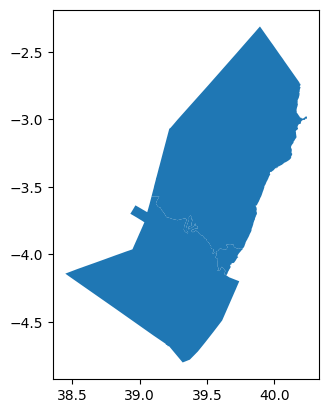

In [101]:
gdf = ox.geocoder.geocode_to_gdf(places)
gdf.plot()
plt.show()

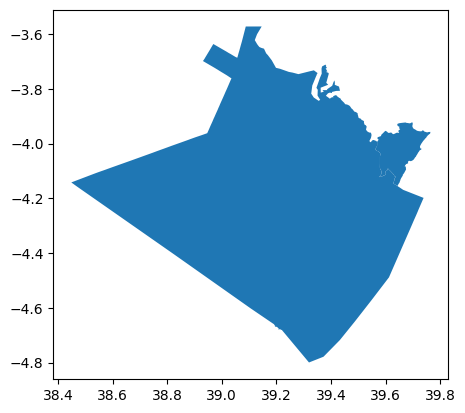

In [116]:
gdf = ox.geocoder.geocode_to_gdf(county_list[0:2])
gdf.plot()
plt.show()